## Datos ICFES


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels
import sklearn.linear_model as lm
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Datos eliminados. Archivo muy pesado. Se trabaja con el archivo limpiado data.csv
data=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Saber_11.csv")


#Limpieza
column_descartadas=data.columns[[0,1,3,4,5,6,8,9,10,11,12,13,16,19,20,22,24,25,26,27,28,33,37,38,41,43,44,45,46,47,48,51,52,53,55,56,57,58,59,61,62,64,65,67,68,70,71,73,74,76,77,78,79,80,81]]#Lista de nombres de columnas a descartar"ESTU_TIPODOCUMENTO","ESTU_NACIONALIDAD","ESTU_NACIONALIDAD","ESTU_"
#Combinar vab de calidad de vida. PCA categórico??
data.drop(column_descartadas, inplace=True,axis=1) 
data.info()
#print(data.describe(include=["O"]))#Descripción categóricas
#data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546212 entries, 0 to 546211
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ESTU_GENERO                    546212 non-null  object 
 1   ESTU_TIENEETNIA                546212 non-null  object 
 2   FAMI_ESTRATOVIVIENDA           546186 non-null  object 
 3   FAMI_PERSONASHOGAR             537749 non-null  object 
 4   FAMI_EDUCACIONPADRE            537920 non-null  object 
 5   FAMI_EDUCACIONMADRE            525253 non-null  object 
 6   FAMI_TIENEINTERNET             537875 non-null  object 
 7   FAMI_TIENECOMPUTADOR           538027 non-null  object 
 8   FAMI_NUMLIBROS                 537558 non-null  object 
 9   FAMI_COMELECHEDERIVADOS        523907 non-null  object 
 10  FAMI_COMECARNEPESCADOHUEVO     536587 non-null  object 
 11  FAMI_COMECEREALFRUTOSLEGUMBRE  523880 non-null  object 
 12  ESTU_DEDICACIONLECTURADIARIA  

In [19]:
#Creacion variables
data=data[data.ESTU_GENERO != "-"]#eliminación filas sin género
data=data[(data.FAMI_ESTRATOVIVIENDA != "-" ) & (data.FAMI_ESTRATOVIVIENDA !="Sin Estrato")& ~( data.FAMI_ESTRATOVIVIENDA.isna())] #Eliminación filas sin especificación de estrato (& realiza elemento a elemento)
data=data[data.FAMI_PERSONASHOGAR != "-"]
data=data[(data.FAMI_EDUCACIONPADRE != "-")&(data.FAMI_EDUCACIONPADRE != "No Aplica")&(data.FAMI_EDUCACIONPADRE !="No sabe")]
data=data[(data.FAMI_EDUCACIONMADRE != "-")&(data.FAMI_EDUCACIONMADRE != "No Aplica")&(data.FAMI_EDUCACIONMADRE !="No sabe")]

data=data[(data.FAMI_TIENEINTERNET != "-")]
data=data[(data.FAMI_TIENECOMPUTADOR != "-")]


data=data[(data.FAMI_NUMLIBROS != "-")]
data=data[(data.ESTU_DEDICACIONLECTURADIARIA !="-")]
data=data[(data.ESTU_DEDICACIONINTERNET !="-")]

data=data[(data.FAMI_COMELECHEDERIVADOS != "-")]
data=data[(data.FAMI_COMECARNEPESCADOHUEVO != "-")]
data=data[(data.FAMI_COMECEREALFRUTOSLEGUMBRE != "-")]

data=data[(data.ESTU_HORASSEMANATRABAJA != "-")]


#Creación variables
data.ESTU_GENERO=pd.get_dummies(data.ESTU_GENERO).M #0 si es mujer, 1 si es hombre
data.ESTU_TIENEETNIA= (data.ESTU_TIENEETNIA=="Si").astype(int)
data.FAMI_ESTRATOVIVIENDA=data.FAMI_ESTRATOVIVIENDA.str.split(" ").str[1].astype(int) #Extraer solo el número del estrato

condiciones = [
    data['FAMI_PERSONASHOGAR'].eq('1 a 2'), data['FAMI_PERSONASHOGAR'].eq('3 a 4'),
    data['FAMI_PERSONASHOGAR'].eq('5 a 6'),data['FAMI_PERSONASHOGAR'].eq('7 a 8'),
    data['FAMI_PERSONASHOGAR'].eq('9 o más')
]
opciones = [1,3,5,7,9]
data.FAMI_PERSONASHOGAR = np.select(condiciones, opciones, default=0)
#data.FAMI_PERSONASHOGAR =(data.FAMI_PERSONASHOGAR >= 7).astype(int)

#data_colegios1
# condiciones = [
#     data.FAMI_EDUCACIONPADRE.eq("Secundaria (Bachillerato) completa") |data.FAMI_EDUCACIONPADRE.eq('Educación profesional completa')
#     |data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica incompleta")
#     |data.FAMI_EDUCACIONPADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONPADRE.eq("Postgrado")
# ]
# opciones=[1]
# data.FAMI_EDUCACIONPADRE=np.select(condiciones, opciones, default=0)
# condiciones = [
#     data.FAMI_EDUCACIONMADRE.eq("Secundaria (Bachillerato) completa") | data.FAMI_EDUCACIONMADRE.eq('Educación profesional completa')
#     | data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica incompleta")
#     |data.FAMI_EDUCACIONMADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONMADRE.eq("Postgrado")
# ]
# opciones=[1]
# data.FAMI_EDUCACIONMADRE=np.select(condiciones, opciones, default=0)


#Data_colegios2
# condiciones = [
#     data.FAMI_EDUCACIONPADRE.eq("Secundaria (Bachillerato) completa") |data.FAMI_EDUCACIONPADRE.eq('Educación profesional completa')
#     |data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica incompleta")
#     |data.FAMI_EDUCACIONPADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONPADRE.eq("Postgrado")
#     |data.FAMI_EDUCACIONMADRE.eq("Secundaria (Bachillerato) completa") | data.FAMI_EDUCACIONMADRE.eq('Educación profesional completa')
#     |data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica incompleta")
#     |data.FAMI_EDUCACIONMADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONMADRE.eq("Postgrado")
# ]

# opciones=[1]
# data["Educacion_padres"]=np.select(condiciones, opciones, default=0)
# data.drop(["FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"], inplace=True,axis=1)

#data_colegios3
condiciones = [
    data.FAMI_EDUCACIONPADRE.eq("Ninguno") |data.FAMI_EDUCACIONMADRE.eq('Ninguno'),
    data.FAMI_EDUCACIONPADRE.eq("Primaria incompleta") |data.FAMI_EDUCACIONMADRE.eq('Primaria incompleta'),
    data.FAMI_EDUCACIONPADRE.eq("Primaria completa") |data.FAMI_EDUCACIONMADRE.eq('Primaria completa'),
    data.FAMI_EDUCACIONPADRE.eq("Secundaria (Bachillerato) incompleta") |data.FAMI_EDUCACIONMADRE.eq('Secundaria (Bachillerato) incompleta'),
    data.FAMI_EDUCACIONPADRE.eq("Secundaria (Bachillerato) completa") |data.FAMI_EDUCACIONMADRE.eq('Secundaria (Bachillerato) completa'),
    data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica incompleta") |data.FAMI_EDUCACIONMADRE.eq('Técnica o tecnológica incompleta'),
    data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica completa") |data.FAMI_EDUCACIONMADRE.eq('Técnica o tecnológica completa'),
    data.FAMI_EDUCACIONPADRE.eq("Educación profesional incompleta") |data.FAMI_EDUCACIONMADRE.eq('Educación profesional incompleta'),
    data.FAMI_EDUCACIONPADRE.eq("Educación profesional completa") |data.FAMI_EDUCACIONMADRE.eq('Educación profesional completa'),
    data.FAMI_EDUCACIONPADRE.eq("Postgrado") |data.FAMI_EDUCACIONMADRE.eq('Postgrado'),
]

opciones=[0,1,2,3,4,5,6,7,8,9]
data["Educacion_padres"]=np.select(condiciones, opciones, default=0)
data.drop(["FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"], inplace=True,axis=1)


#Conectividad
condiciones = [
    data.FAMI_TIENECOMPUTADOR.eq("Si") |data.FAMI_TIENEINTERNET.eq('Si')
]
opciones=[1]
data.FAMI_TIENECOMPUTADOR=np.select(condiciones, opciones, default=0)


data.drop("FAMI_TIENEINTERNET", inplace=True,axis=1)
data.rename(columns = {'FAMI_TIENECOMPUTADOR':'conectividad'}, inplace = True) #se puede cambiar: asignar a data["conectividad"] directamente
#Libros
condiciones = [
    data['FAMI_NUMLIBROS'].eq('0 A 10 LIBROS'), data['FAMI_NUMLIBROS'].eq('11 A 25 LIBROS'),
    data['FAMI_NUMLIBROS'].eq('26 A 100 LIBROS'),data['FAMI_NUMLIBROS'].eq('MÁS DE 100 LIBROS')
]
opciones = [10,25,50,100]
data.FAMI_NUMLIBROS=np.select(condiciones, opciones, default=0)
#Dedicación
condiciones = [
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('No leo por entretenimiento'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('30 minutos o menos'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('Entre 30 y 60 minutos'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('Entre 1 y 2 horas'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('Más de 2 horas')
]
opciones = [0,3,6,12,18]
data.ESTU_DEDICACIONLECTURADIARIA=np.select(condiciones, opciones, default=0)

condiciones = [
    data['ESTU_DEDICACIONINTERNET'].eq('No Navega Internet'),
    data['ESTU_DEDICACIONINTERNET'].eq('30 minutos o menos'),
    data['ESTU_DEDICACIONINTERNET'].eq('Entre 30 y 60 minutos'),
    data['ESTU_DEDICACIONINTERNET'].eq('Entre 1 y 3 horas'),
    data['ESTU_DEDICACIONINTERNET'].eq('Más de 3 horas')
]
opciones = [0,3,6,12,18]
data.ESTU_DEDICACIONINTERNET=np.select(condiciones, opciones, default=0)

#Alimentación
condiciones = [
    data['FAMI_COMELECHEDERIVADOS'].eq('3 a 5 veces por semana')| data['FAMI_COMELECHEDERIVADOS'].eq('Todos o casi todos los días')
]
opciones = [1]
data.FAMI_COMELECHEDERIVADOS=np.select(condiciones, opciones, default=0)

condiciones = [
    data['FAMI_COMECARNEPESCADOHUEVO'].eq('3 a 5 veces por semana')| data['FAMI_COMECARNEPESCADOHUEVO'].eq('Todos o casi todos los días')
]
opciones = [1]
data.FAMI_COMECARNEPESCADOHUEVO=np.select(condiciones, opciones, default=0)

condiciones = [
    data['FAMI_COMECEREALFRUTOSLEGUMBRE'].eq('3 a 5 veces por semana')| data['FAMI_COMECEREALFRUTOSLEGUMBRE'].eq('Todos o casi todos los días')
]
opciones = [1]
data.FAMI_COMECEREALFRUTOSLEGUMBRE=np.select(condiciones, opciones, default=0)

data["alimentacion"]=data[['FAMI_COMELECHEDERIVADOS', 'FAMI_COMECARNEPESCADOHUEVO','FAMI_COMECEREALFRUTOSLEGUMBRE']].sum(axis=1)
data.alimentacion=(data.alimentacion>=2).astype(int)

data.drop(['FAMI_COMELECHEDERIVADOS','FAMI_COMECARNEPESCADOHUEVO','FAMI_COMECEREALFRUTOSLEGUMBRE'], inplace=True,axis=1)
#Trabaja
data.ESTU_HORASSEMANATRABAJA=(~ data.ESTU_HORASSEMANATRABAJA.eq('0')).astype(int)
#Oficiales/no oficiales
data.COLE_NATURALEZA=(data.COLE_NATURALEZA.eq("NO OFICIAL")).astype(int)
#Rural/urbano
data.COLE_AREA_UBICACION=(data.COLE_AREA_UBICACION.eq("URBANO")).astype(int)

#Agrupación por colegio
#'ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS' tienen relevancia para análisis individual
#data_colegios1=data.groupby(['COLE_NOMBRE_ESTABLECIMIENTO','COLE_NATURALEZA','COLE_AREA_UBICACION','COLE_DEPTO_UBICACION'],as_index=False)[['ESTU_TIENEETNIA','FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']].mean()

#data_colegios2 y 3
data_colegios2=data.groupby(['COLE_NOMBRE_ESTABLECIMIENTO','COLE_NATURALEZA','COLE_AREA_UBICACION','COLE_DEPTO_UBICACION'],as_index=False)[['ESTU_TIENEETNIA','FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','Educacion_padres','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']].mean()

#Columnas consideradas en la regresión
#data_reg=data_colegios[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]

#Creación archivo
#data_colegios2.to_csv(path_or_buf="C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/Proyecto-Econometria-I/data_colegios3.csv")


In [5]:
#Lectura de archivo creado 
# datos=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/Proyecto-Econometria-I/data_colegios1.csv")
# data_reg=datos[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]

# datos=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/Proyecto-Econometria-I/data_colegios2.csv")
# data_reg=datos[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','Educacion_padres','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]

datos=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/Proyecto-Econometria-I/data_colegios3.csv")
data_reg=datos[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','Educacion_padres','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]

In [7]:

#sns.boxplot(x="COLE_AREA_UBICACION",y="PUNT_GLOBAL",data=data_reg)
#sns.boxplot(x="COLE_NATURALEZA",y="PUNT_GLOBAL",data=data_reg)#.iloc[:,1:])

#sns.heatmap(data_reg.corr(),cmap="Blues")
#data_reg.corr()
#data_reg.info()

#sns.FacetGrid(data_reg,hue="COLE_AREA_UBICACION",height=3)\
#   .map(sns.distplot,"PUNT_GLOBAL")\
#    .add_legend() 
#plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10024 entries, 0 to 10023
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   COLE_NATURALEZA          10024 non-null  int64  
 1   COLE_AREA_UBICACION      10024 non-null  int64  
 2   ESTU_TIENEETNIA          10024 non-null  float64
 3   FAMI_ESTRATOVIVIENDA     10024 non-null  float64
 4   FAMI_PERSONASHOGAR       10024 non-null  float64
 5   FAMI_EDUCACIONPADRE      10024 non-null  float64
 6   FAMI_EDUCACIONMADRE      10024 non-null  float64
 7   conectividad             10024 non-null  float64
 8   alimentacion             10024 non-null  float64
 9   ESTU_HORASSEMANATRABAJA  10024 non-null  float64
 10  PUNT_GLOBAL              10024 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 861.6 KB


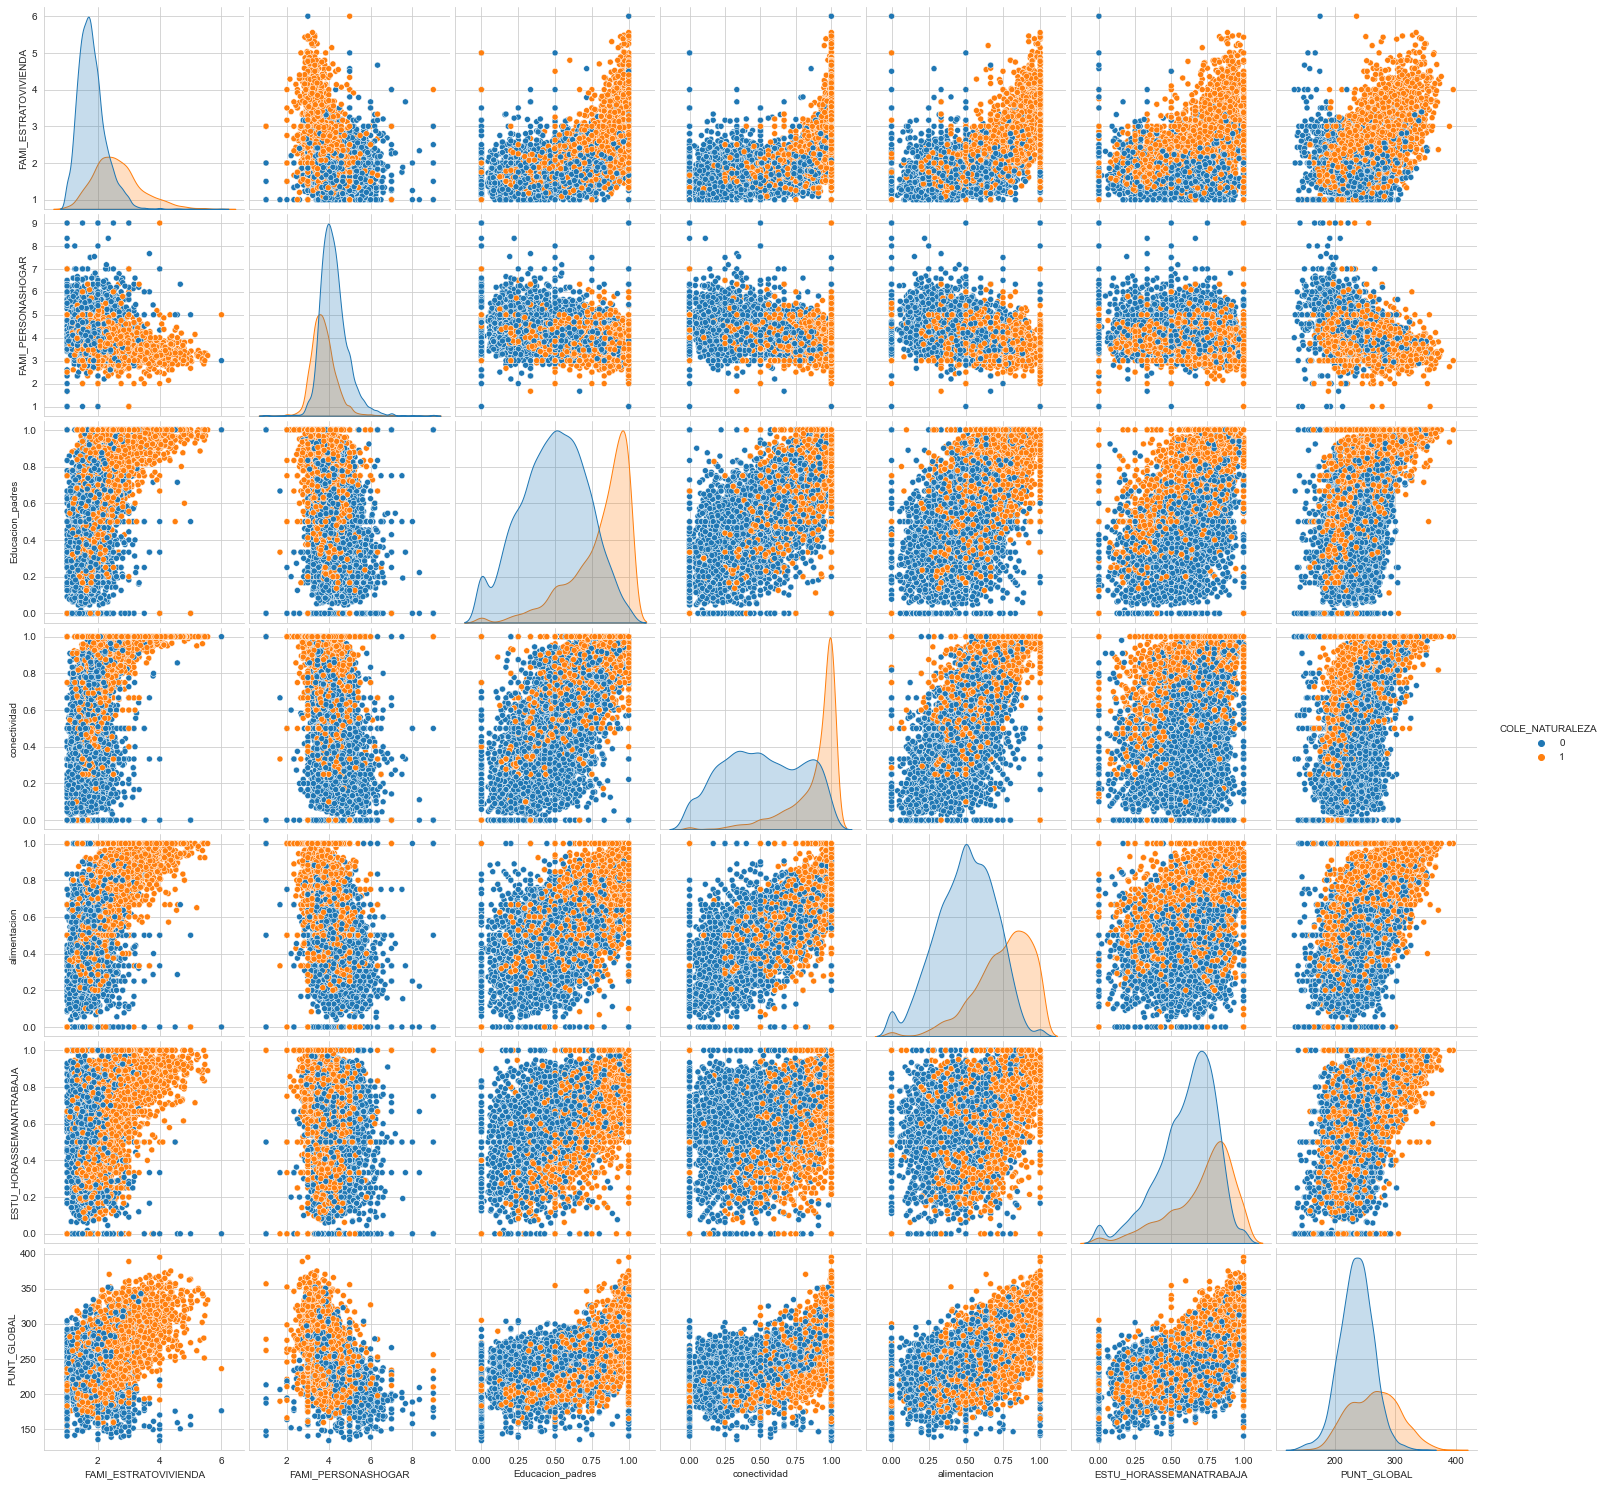

In [26]:
# cuanti=data_reg[['COLE_NATURALEZA','FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]
# plt.close()
# sns.set_style("whitegrid")
# sns.pairplot(cuanti,hue="COLE_NATURALEZA",height=3)
# plt.show()

cuanti=data_reg[['COLE_NATURALEZA','FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','Educacion_padres','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]
plt.close()
sns.set_style("whitegrid")
sns.pairplot(cuanti,hue="COLE_NATURALEZA",height=3)
plt.show()

In [ ]:
data_reg.ESTU_TIENEETNIA=np.log(data_reg.ESTU_TIENEETNIA)
data_reg.loc[data_reg.ESTU_TIENEETNIA.eq(-np.inf)]
#data_reg.FAMI_PERSONASHOGAR=np.log(data_reg.FAMI_PERSONASHOGAR) Si ponemos como dummy
data_reg.FAMI_EDUCACIONPADRE=np.log(data_reg.FAMI_EDUCACIONPADRE)
data_reg.FAMI_EDUCACIONMADRE=np.log(data_reg.FAMI_EDUCACIONMADRE)
data_reg.conectividad=np.log(data_reg.conectividad)
data_reg.alimentacion=np.log(data_reg.alimentacion)



In [6]:
# X = sm.add_constant(data_reg[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA']])
# reg = sm.OLS(data_reg["PUNT_GLOBAL"],X)
# resultados=reg.fit()
# print(resultados.summary())


X = sm.add_constant(data_reg[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','Educacion_padres','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA']])
reg = sm.OLS(data_reg["PUNT_GLOBAL"],X)
resultados=reg.fit()
print(resultados.summary())

c:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:            PUNT_GLOBAL   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     1561.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        11:59:34   Log-Likelihood:                -44662.
No. Observations:               10016   AIC:                         8.935e+04
Df Residuals:                   10003   BIC:                         8.944e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [43]:
#Regresión de educación padres en función de las demás vab
X = sm.add_constant(data_reg[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','conectividad','alimentacion']])
reg = sm.OLS(data_reg['Educacion_padres'],X)
resultados=reg.fit()
print(resultados.summary())

                            OLS Regression Results                            
Dep. Variable:       Educacion_padres   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     3394.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        18:17:56   Log-Likelihood:                -11929.
No. Observations:               10016   AIC:                         2.387e+04
Df Residuals:                   10008   BIC:                         2.393e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1518 

In [41]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                   feature        VIF
0                    const  80.253571
1          COLE_NATURALEZA   1.903513
2      COLE_AREA_UBICACION   1.685619
3          ESTU_TIENEETNIA   1.194450
4     FAMI_ESTRATOVIVIENDA   2.708334
5       FAMI_PERSONASHOGAR   1.353155
6         Educacion_padres   4.015928
7             conectividad   3.520834
8             alimentacion   2.690894
9  ESTU_HORASSEMANATRABAJA   1.545875
